In [7]:
%load_ext autoreload
%autoreload 2

In [62]:
from RealDataSimulation.datasources.download import DownloadManager
from RealDataSimulation.datasources.geostat import STATPOP, STATENT
from RealDataSimulation.simulation import Area, Simulation
from RealDataSimulation.TaskManagers.TaskManager import TaskManager


In [53]:
from datetime import datetime, timedelta

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
download_with_cache("https://www.bfs.admin.ch/bfsstatic/dam/assets/32686751/master", "STATPOT2023.csv", zip=True, zip_file_name="STATPOP2023.csv", method="GET")

('data\\1_downloaded\\STATPOT2023.csv', datetime.date(2025, 1, 2))

In [38]:
df = pd.read_csv('data\\1_downloaded\\STATPOT2023.csv', sep=";")
df

,ERHJAHR,PUBJAHR,RELI,E_KOORD,N_KOORD,BBTOT,BB11,BB12,BB13,BB14,...,BB55,BB56,HPTOT,HP01,HP02,HP03,HP04,HP05,HP06,HPI
0,2023,2024,48621114,2486200,1111400,5,4,3,3,0,...,0,0,3,3,3,0,0,0,0,1.0
1,2023,2024,48621115,2486200,1111500,3,3,0,0,0,...,0,0,3,3,0,0,0,0,0,1.0
2,2023,2024,48631114,2486300,1111400,4,4,0,0,0,...,0,0,3,0,0,0,3,0,0,1.0
3,2023,2024,48631117,2486300,1111700,3,3,0,0,0,...,0,0,3,0,0,3,0,0,0,1.0
4,2023,2024,48641116,2486400,1111600,30,22,8,7,0,...,0,0,11,3,3,5,3,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347403,2023,2024,83101690,2831000,1169000,3,3,0,0,0,...,0,0,3,0,0,3,0,0,0,1.0
347404,2023,2024,83101692,2831000,1169200,3,3,0,0,0,...,0,0,3,3,3,0,0,0,0,1.0
347405,2023,2024,83111692,2831100,1169200,3,3,0,0,0,...,0,0,3,3,0,0,0,0,0,1.0
347406,2023,2024,83111693,2831100,1169300,9,9,0,0,0,...,0,0,4,3,3,3,0,0,0,1.0


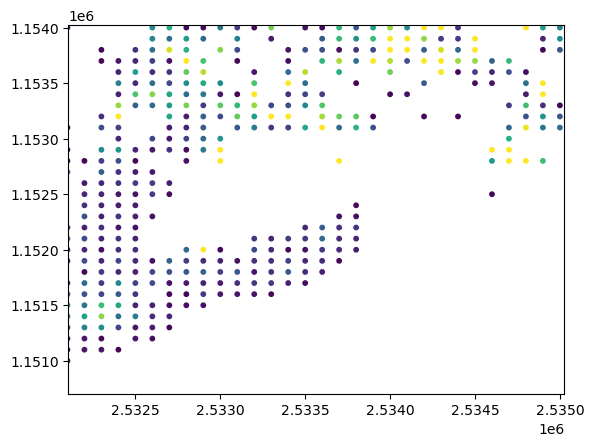

In [57]:
plt.scatter(data=df, x="E_KOORD", y="N_KOORD", c="BBTOT", s=10,  vmin=0, vmax=200)
plt.xlim(2532106,2535027)
plt.ylim(1150700,1154028)
plt.show()

In [47]:
df.BBTOT.max()

np.int64(4046)

In [65]:
next(iter(ASSETS_PER_YEAR.keys()))

2023

In [7]:
epfl = Simulation("EPFL", {"x_min":2532106, "x_max":2535027, "y_min":1150700, "y_max":1154028}, 0, 100, 1)
epfl.plot_interactive()

In [19]:
population = STATPOP(epfl)
population.df

,POSITION_X,POSITION_Y,POPULATION
18317,2532100,1151000,6
18318,2532100,1151100,6
18319,2532100,1151200,9
18320,2532100,1151300,30
18321,2532100,1151400,73
...,...,...,...
20105,2535000,1153200,54
20106,2535000,1153300,3
20107,2535000,1153800,52
20108,2535000,1153900,98


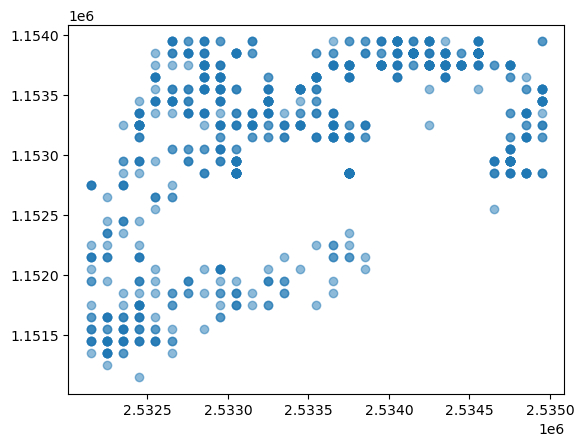

array([[2532250, 1151350],
       [2533850, 1153850],
       [2534250, 1153750],
       ...,
       [2532650, 1152650],
       [2534050, 1153950],
       [2532450, 1152150]], shape=(904, 2))

In [21]:
pop_demand = population.generate_n(1000, seed = 10)
plt.scatter(pop_demand[:, 0], pop_demand[:, 1], alpha=0.5)
plt.show()
pop_demand

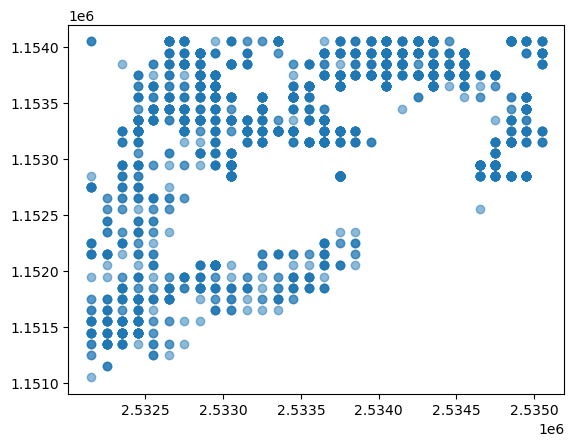

In [377]:
pop_demand2 = population.generate_per_proportion(0.1, seed = 100)
plt.scatter(pop_demand2[:, 0], pop_demand2[:, 1], alpha=0.5)

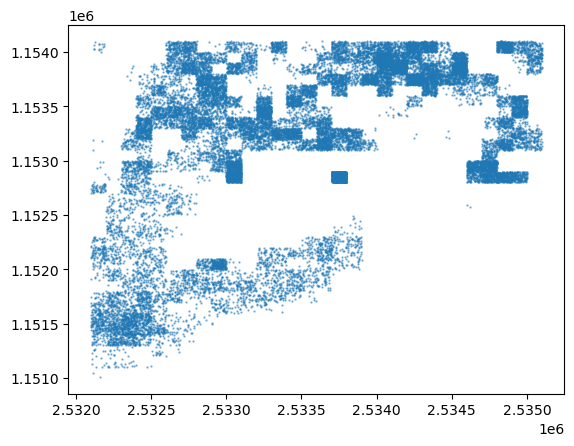

array([[2533676.5, 1153383.5],
       [2532912.5, 1151859.5],
       [2533208.5, 1153428.5],
       ...,
       [2532663.5, 1153916.5],
       [2534840.5, 1152866.5],
       [2534282.5, 1154083.5]], shape=(27262, 2))

In [379]:
pop_demand_jitter = population.generate_per_proportion(proportion=1, precision_in_meter=1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=0.5)
plt.show()
pop_demand_jitter

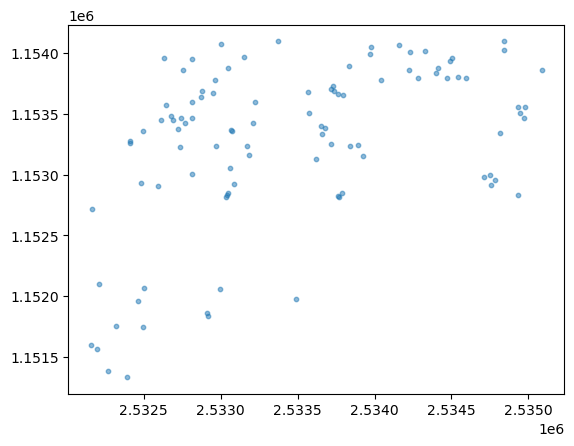

In [381]:
pop_demand_jitter = population.generate_n(100, precision_in_meter=1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10)
plt.show()

In [16]:
statent = STATENT(epfl)
statent.df

,POSITION_X,POSITION_Y,SHOPS,SHOPS_EMP,SHOPS_ETP,SHOPS_0,SHOPS_10,SHOPS_50,SHOPS_250
12331,2532100,1151300,0,0,0.0,0,0,0,0
12332,2532100,1151400,0,0,0.0,0,0,0,0
12333,2532100,1151500,0,0,0.0,0,0,0,0
12334,2532100,1151700,0,0,0.0,0,0,0,0
12335,2532100,1151900,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
13730,2535000,1153600,0,0,0.0,0,0,0,0
13731,2535000,1153700,0,0,0.0,0,0,0,0
13732,2535000,1153800,0,0,0.0,0,0,0,0
13733,2535000,1153900,4,4,4.0,4,0,0,0


In [17]:
entreprises = statent.get_entreprises(1, seed=100)
entreprises.df

AttributeError: 'STATENT' object has no attribute 'simulation'

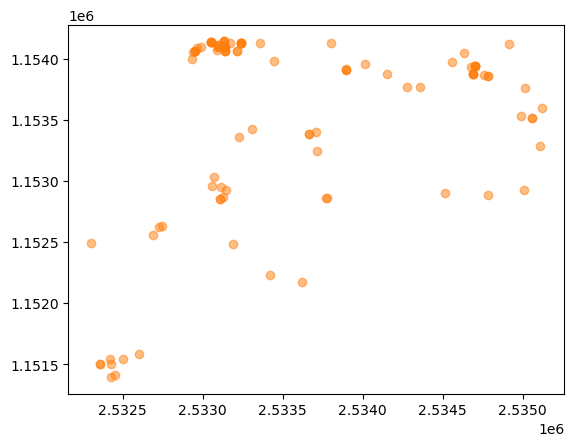

array([[2534688.5, 1153870.5],
       [2532427.5, 1151394.5],
       [2533892.5, 1153905.5],
       [2534559.5, 1153974.5],
       [2533211.5, 1154064.5],
       [2533147.5, 1152924.5],
       [2532951.5, 1154058.5],
       [2534688.5, 1153870.5],
       [2532950.5, 1154059.5],
       [2532689.5, 1152554.5],
       [2534273.5, 1153763.5],
       [2535106.5, 1153285.5],
       [2532302.5, 1152491.5],
       [2533237.5, 1154123.5],
       [2534700.5, 1153941.5],
       [2533776.5, 1152860.5],
       [2534514.5, 1152897.5],
       [2533115.5, 1152952.5],
       [2534991.5, 1153527.5],
       [2534360.5, 1153767.5],
       [2533418.5, 1152231.5],
       [2532942.5, 1154050.5],
       [2533128.5, 1154108.5],
       [2534152.5, 1153875.5],
       [2533186.5, 1152487.5],
       [2533141.5, 1154097.5],
       [2533802.5, 1154130.5],
       [2533237.5, 1154123.5],
       [2534012.5, 1153952.5],
       [2533708.5, 1153400.5],
       [2534700.5, 1153941.5],
       [2533237.5, 1154123.5],
       [

In [419]:
ent_sources = entreprises.generate_n(100, seed = 10)
plt.scatter(ent_sources[:, 0], ent_sources[:, 1], alpha=0.5, c="C1")
plt.show()
ent_sources

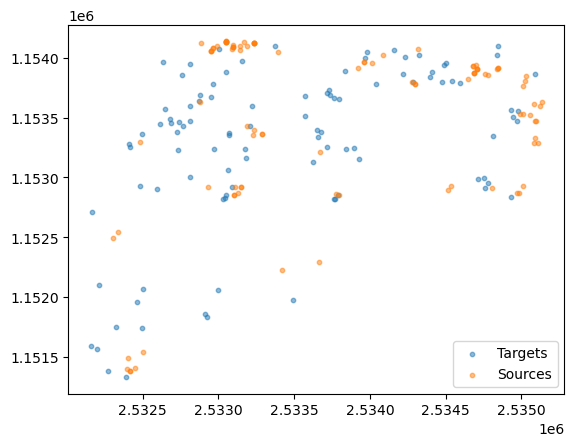

In [421]:
pop_demand_jitter = population.generate_n(100, 1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10, label="Targets")
ent_sources_jitter = entreprises.generate_n(100, seed = 200)
plt.scatter(ent_sources_jitter[:, 0], ent_sources_jitter[:, 1], alpha=0.5, s=10, c="C1", label="Sources")
plt.legend()
plt.show()

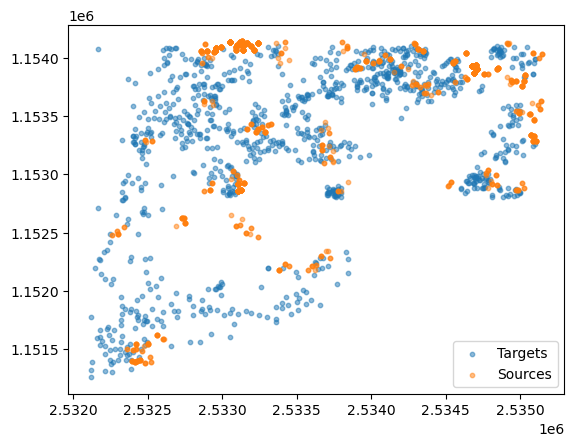

In [422]:
pop_demand_jitter = population.generate_n(1000, 1, seed = 100)
plt.scatter(pop_demand_jitter[:, 0], pop_demand_jitter[:, 1], alpha=0.5, s=10, label="Targets")
ent_sources_jitter = entreprises.generate_n(1000, seed = 200)
plt.scatter(ent_sources_jitter[:, 0], ent_sources_jitter[:, 1], alpha=0.5, s=10, c="C1", label="Sources")
plt.legend()
plt.show()

## Try TaskManager

In [10]:
epfl = Simulation("EPFL", {"x_min":2532106, "x_max":2535027, "y_min":1150700, "y_max":1154028}, 0, 100, 1)
epfl.plot_interactive()

In [11]:
tasks_manager = TaskManager(epfl, random_seed=100)
tasks_manager.get_tasks(100, random_seed=100)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

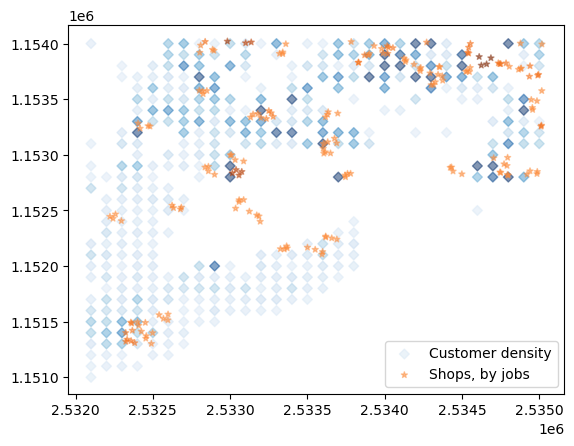

In [125]:
tasks_manager.plot()
plt.legend(scatterpoints=1)

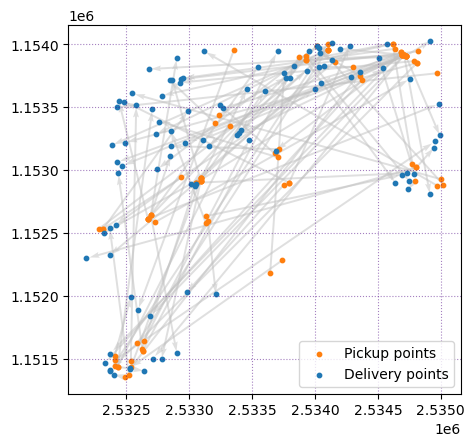

In [25]:
plt.figure()
tasks_manager.plot(plt.gca(), tasks_manager.get_tasks(100))
plt.gca().set_aspect("equal")
plt.grid(linestyle=":", color="indigo", alpha=0.5)
plt.legend(scatterpoints=1)

## Map

In [21]:
import smopy

In [52]:
datetime.today()

datetime.datetime(2025, 1, 5, 15, 2, 2, 148879)

In [63]:
epfl = Simulation("EPFL", {"x_min":2532106, "x_max":2535027, "y_min":1150700, "y_max":1154028}, datetime.today()-timedelta(hours=1), datetime.today(), timedelta(seconds=1))
epfl.plot_interactive()

Lowered zoom level to keep map size reasonable. (z = 14)


c:\Users\arsju\OneDrive\Documents\1 Etudes\EPFL MA3 2024-2025\PROJETS\DRONES\RealDataSimulation\Simulation.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\arsju\AppData\Local\Temp\ipykernel_3644\2621981229.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


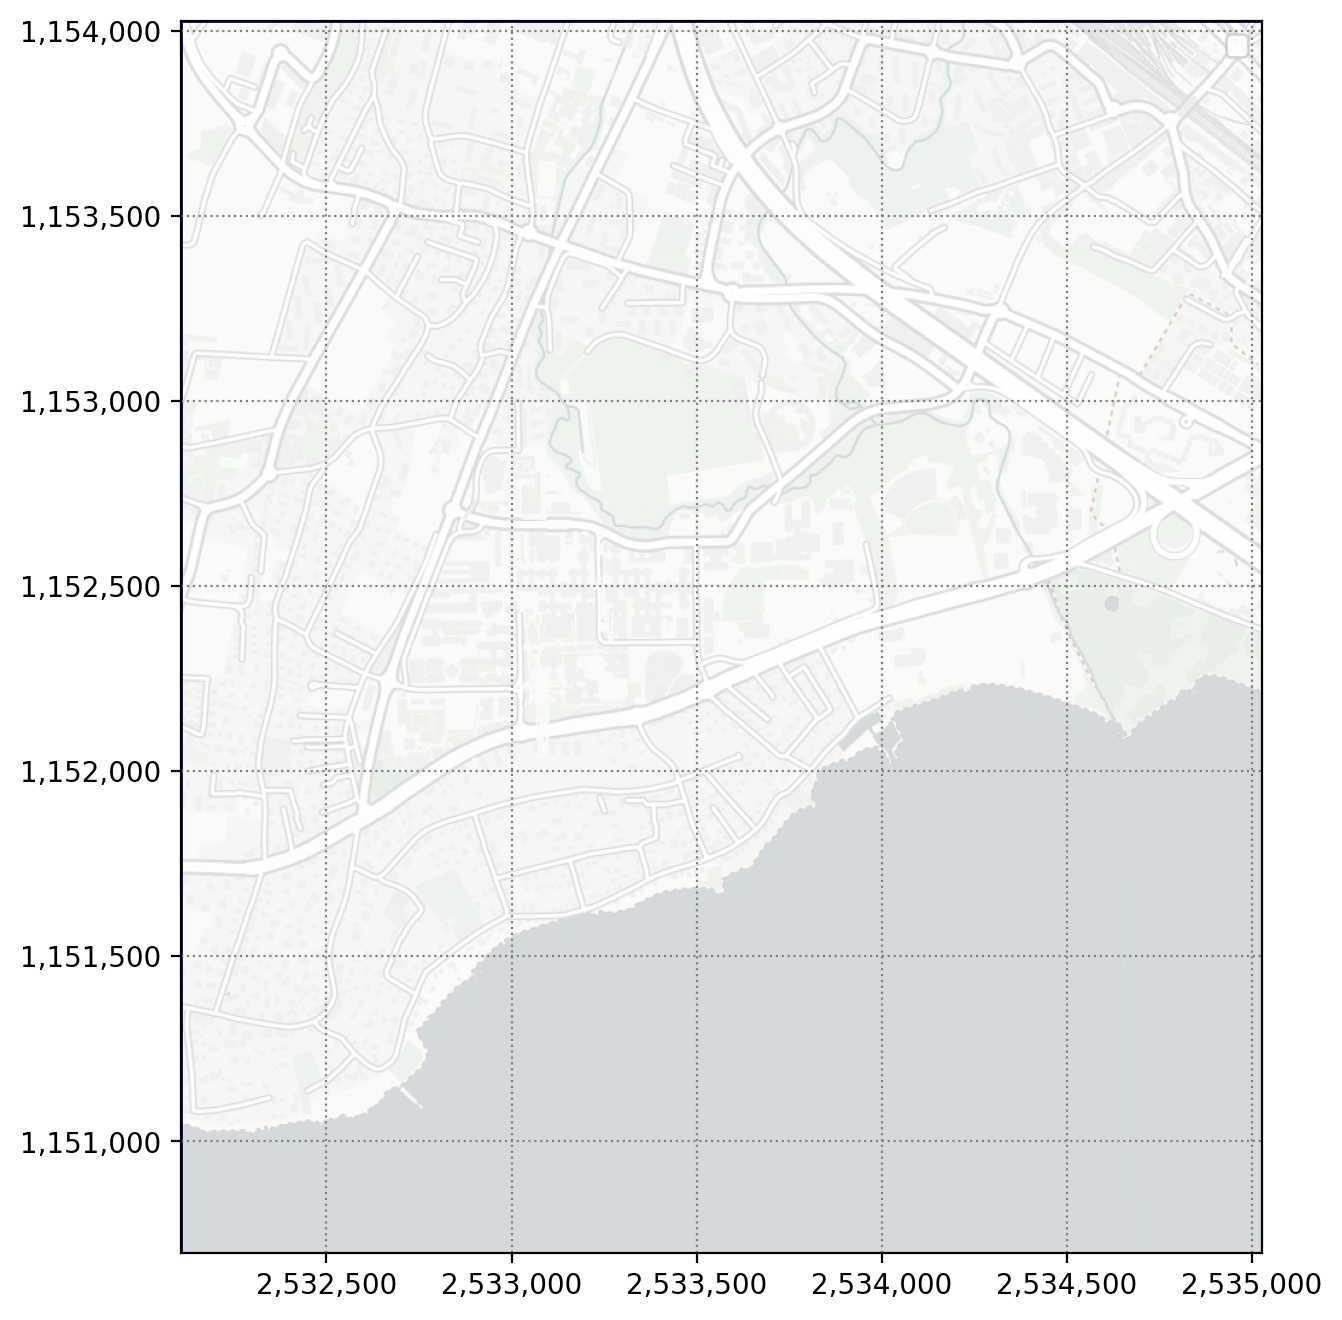

In [13]:
fig, ax = epfl.plot()
fig.show()

Lowered zoom level to keep map size reasonable. (z = 13)


C:\Users\arsju\AppData\Local\Temp\ipykernel_3644\3001758358.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


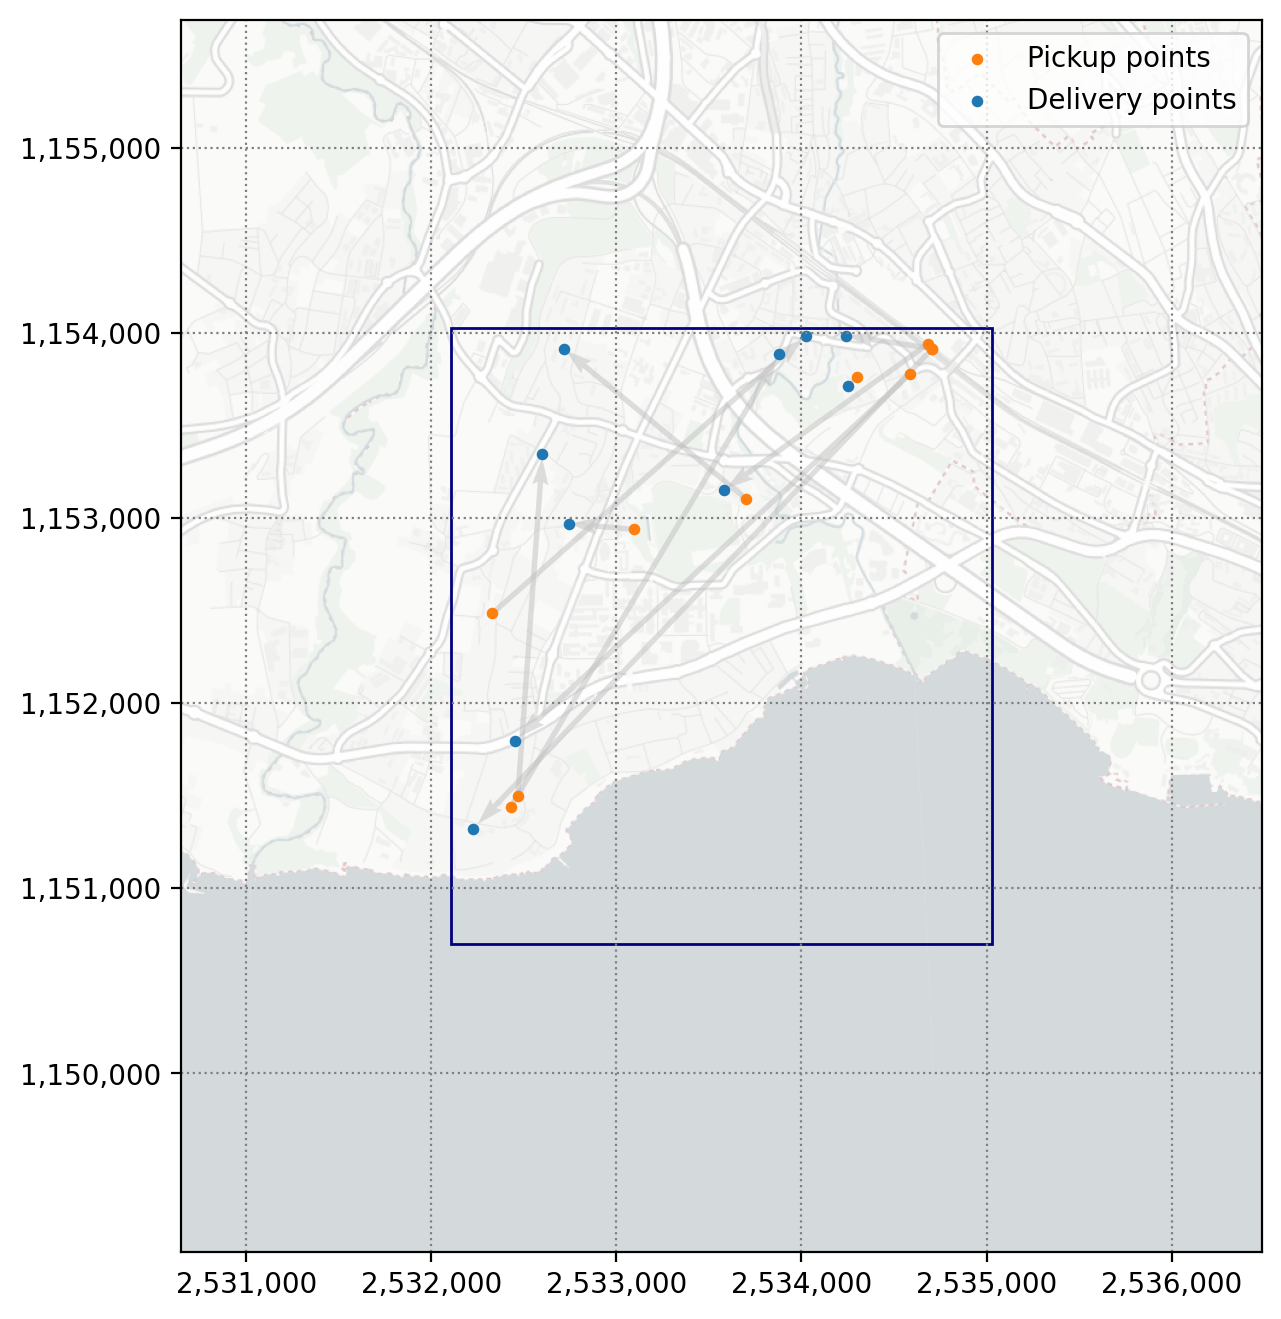

In [26]:
fig, ax = epfl.plot((tasks_manager, tasks_manager.get_tasks(10, random_seed=10)), margin=0.5)
fig.show()

## Test TransportData

In [50]:
from RealDataSimulation.datasources.opentransport import TransportData
from RealDataSimulation.datasources.download import DownloadManager

In [77]:
tp = TransportData(epfl, date = datetime(2025,1,3).date())
tp.download_data(date_strict=False)

('data\\1_downloaded\\Stops_2025-01-03.csv',
 'data\\1_downloaded\\Timetable_2025-01-03.csv')

In [78]:
tp.filter_data(return_data=False)

In [124]:
timetables = tp.generate_timetable()

85:151:1
44
28
12
85:151:24
85:151:25
85:151:31
85:151:32
4
85:151:33
Removing 154 duplicates for line 33 (85:151:33)
85:151:70
85:151:95
Removing 3 duplicates for line N5 (85:151:95)
52
85:764:701
Removing 91 duplicates for line 701 (85:764:701)
8
85:764:705
Removing 2 duplicates for line 705 (85:764:705)
12


In [126]:
pd.DataFrame.groupby?

Signature:
pd.DataFrame.groupby(
    self,
    by=None,
    axis: 'Axis | lib.NoDefault' = <no_default>,
    level: 'IndexLabel | None' = None,
    as_index: 'bool' = True,
    sort: 'bool' = True,
    group_keys: 'bool' = True,
    observed: 'bool | lib.NoDefault' = <no_default>,
    dropna: 'bool' = True,
) -> 'DataFrameGroupBy'
Docstring:
Group DataFrame using a mapper or by a Series of columns.

A groupby operation involves some combination of splitting the
object, applying a function, and combining the results. This can be
used to group large amounts of data and compute operations on these
groups.

Parameters
----------
by : mapping, function, label, pd.Grouper or list of such
    Used to determine the groups for the groupby.
    If ``by`` is a function, it's called on each value of the object's
    index. If a dict or Series is passed, the Series or dict VALUES
    will be used to determine the groups (the Series' values are first
    aligned; see ``.align()`` method). If a list 

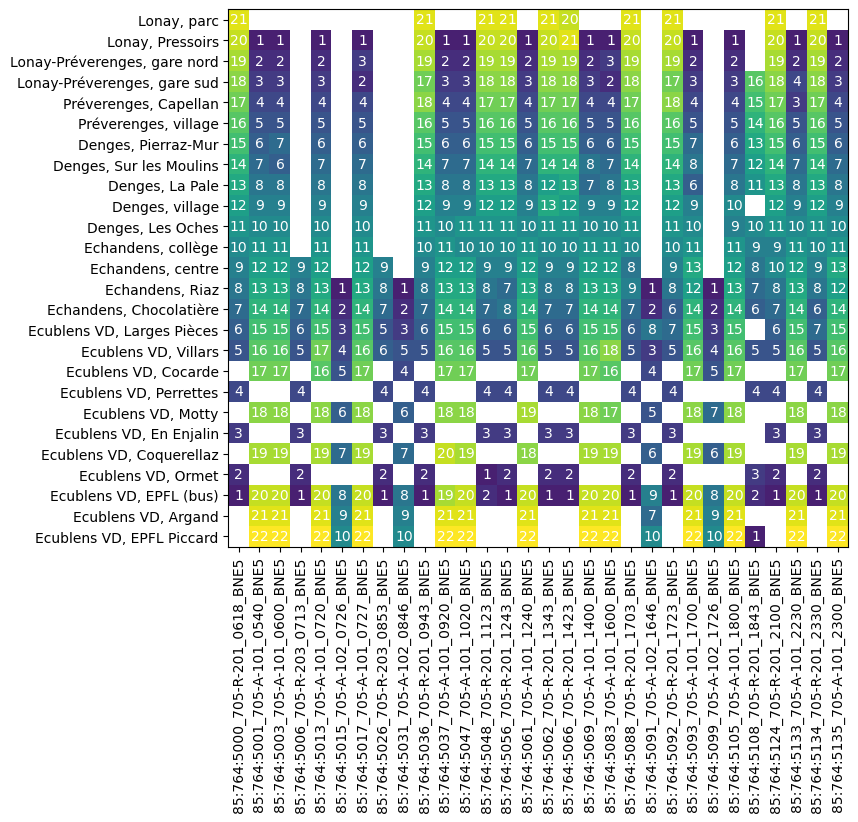

In [170]:
line_timetable: pd.DataFrame = timetables["85:764:705"]["real"]
journeys = line_timetable.drop(["POSITION_X", "POSITION_Y"], axis=1).groupby("STOP_NAME", sort=False).first()

journeys = journeys.apply(lambda x: x.dropna().argsort(), axis=0).fillna(-1).sort_values(by="DISTANCE")
unique_journeys = journeys.T.drop("DISTANCE").drop_duplicates().astype("int").T

plt.figure(figsize = (8,8))
plt.imshow(unique_journeys, alpha=(unique_journeys>0).astype("short"))
plt.xticks(np.arange(len(unique_journeys.columns)),unique_journeys.columns, rotation=90)
plt.yticks(np.arange(len(unique_journeys.index)),unique_journeys.index)

ax = plt.gca()
for i in range(unique_journeys.shape[0]):
    for j in range(unique_journeys.shape[1]):
        text = ax.text(j, i, unique_journeys.iloc[i, j],
                       ha="center", va="center", color="w")
plt.show()


count,38,37,13,13,5,4,3,3,2,2,...,1,1,1,1,1,1,1,1,1,1
"Lonay, parc",21,0,-1,-1,0,21,21,-1,0,21,...,0,0,21,20,0,0,21,21,21,21
"Lonay, Pressoirs",20,1,-1,-1,1,20,20,-1,1,20,...,1,1,20,21,1,1,20,20,20,20
"Lonay-Préverenges, gare nord",19,2,-1,-1,3,19,19,-1,2,19,...,2,2,19,19,3,2,19,19,19,19
"Lonay-Préverenges, gare sud",18,3,-1,-1,2,17,18,-1,3,18,...,3,3,17,18,2,4,18,18,18,18
"Préverenges, Capellan",17,4,-1,-1,4,18,17,-1,4,17,...,4,4,18,17,4,3,17,17,17,17
"Préverenges, village",16,5,-1,-1,5,16,16,-1,5,16,...,5,5,16,16,5,5,16,16,16,16
"Denges, Pierraz-Mur",15,6,-1,-1,6,15,15,-1,6,15,...,7,7,15,15,6,6,15,15,15,15
"Denges, Sur les Moulins",14,7,-1,-1,7,14,14,-1,8,14,...,8,6,14,14,7,7,14,14,14,14
"Denges, La Pale",13,8,-1,-1,8,13,13,-1,7,12,...,6,8,13,13,8,8,13,13,13,13
"Denges, village",12,9,-1,-1,9,12,12,-1,9,13,...,9,9,12,12,9,9,12,12,12,12


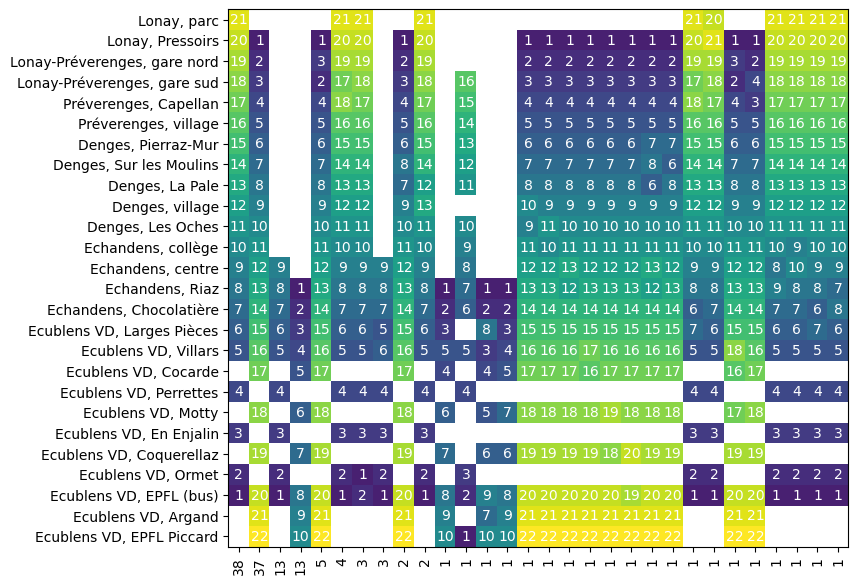

In [168]:
unique_journeys = journeys.T.drop("DISTANCE").value_counts().reset_index().astype("int").set_index("count").T
display(unique_journeys)
plt.figure(figsize = (8,8))
plt.imshow(unique_journeys, alpha=(unique_journeys>0).astype("short"))
plt.xticks(np.arange(len(unique_journeys.columns)),unique_journeys.columns, rotation=90)
plt.yticks(np.arange(len(unique_journeys.index)),unique_journeys.index)

ax = plt.gca()
for i in range(unique_journeys.shape[0]):
    for j in range(unique_journeys.shape[1]):
        text = ax.text(j, i, unique_journeys.iloc[i, j],
                       ha="center", va="center", color="w")
plt.show()


## Brol

In [6]:
a = np.arange(10).reshape((-1,2))
a[:3]

array([[0, 1],
       [2, 3],
       [4, 5]])

In [2]:
import numpy as np

In [141]:
np.random.Generator.integers(5, size=(10,2)) * 20

TypeError: integers() takes at least 1 positional argument (0 given)

In [145]:
np.random.default_rng?

Signature:      np.random.default_rng(seed=None)
Call signature: np.random.default_rng(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction default_rng at 0x000002173823DA40>
Docstring:     
default_rng(seed=None)
Construct a new Generator with the default BitGenerator (PCG64).

    Parameters
    ----------
    seed : {None, int, array_like[ints], SeedSequence, BitGenerator, Generator, RandomState}, optional
        A seed to initialize the `BitGenerator`. If None, then fresh,
        unpredictable entropy will be pulled from the OS. If an ``int`` or
        ``array_like[ints]`` is passed, then all values must be non-negative and will be
        passed to `SeedSequence` to derive the initial `BitGenerator` state. One may also
        pass in a `SeedSequence` instance.
        Additionally, when passed a `BitGenerator`, it will be wrapped by
        `Generator`. If passed a `Generator`, it will be returned unaltered.
        When passed a legacy `Rando

In [32]:
from datetime import datetime

In [33]:
datetime1 = datetime(2024, 12, 10, 12, 0, 0)
datetime1.date()

datetime.date(2024, 12, 10)

In [34]:
df = pd.read_csv("data/1_downloaded/Timetable_2024-12-10.csv", sep=";", low_memory=False)
df.sample(5)

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,BETREIBER_ABK,BETREIBER_NAME,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,UMLAUF_ID,VERKEHRSMITTEL_TEXT,...,FAELLT_AUS_TF,BPUIC,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
2284556,10.12.2024,85:883:66739-0,85:883,BSU,Busbetrieb Solothurn und Umgebung,Bus,85:883:7,7,723,B,...,False,8587367,"Röthenbach b. H., Rest. Post",10.12.2024 10:45,10.12.2024 10:46:43,REAL,10.12.2024 10:45,10.12.2024 10:46:56,REAL,False
2060988,10.12.2024,85:881:TPG009-4503784321757755,85:881,TPG,Transports Publics Genevois,Bus,85:881:TPG009,9,NaN,B,...,False,8592797,"Genève, Camille-Martin",10.12.2024 15:57,10.12.2024 15:56:11,PROGNOSE,10.12.2024 15:57,10.12.2024 15:56:25,PROGNOSE,False
2040823,10.12.2024,85:881:TPG005-4503784321268771,85:881,TPG,Transports Publics Genevois,Bus,85:881:TPG005,5,NaN,B,...,False,8592950,"Grand-Saconnex, Palexpo",10.12.2024 14:23,10.12.2024 14:23:03,PROGNOSE,10.12.2024 14:23,10.12.2024 14:23:29,PROGNOSE,False
2137707,10.12.2024,85:881:TPG022-4503784321217168,85:881,TPG,Transports Publics Genevois,Bus,85:881:TPG022,22,NaN,B,...,False,8587437,"Carouge GE, Rondeau",10.12.2024 13:14,10.12.2024 13:12:06,PROGNOSE,NaN,NaN,NaN,False
1197477,10.12.2024,85:811:70351-0070,85:811,AAGL,Autobus AG Liestal,Bus,85:811:70,70,NaN,B,...,False,8578323,Bubendorf Unterdorf,10.12.2024 12:39,10.12.2024 12:41:38,REAL,10.12.2024 12:39,10.12.2024 12:41:39,REAL,False


In [35]:
df.PRODUKT_ID.value_counts()

PRODUKT_ID
Bus            1920328
Tram            253166
Zug             163500
BUS             112255
Metro             5101
Zahnradbahn       1653
Schiff             176
Name: count, dtype: int64

In [44]:
', '.join(df.PRODUKT_ID.iloc[:5].astype(str))

'Zug, Zug, Zug, Zug, Zug'

In [47]:
df.ANKUNFTSZEIT.is_unique

False